[View in Colaboratory](https://colab.research.google.com/github/Muosvr/fastai/blob/master/lesson1_rxt50.ipynb)

## Dogs v Cats super-charged!

In [0]:
#Further learning lession 1 at fast.ai: http://course.fast.ai/lessons/lesson1.html

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#install pytorch to be able to make computations on GPUs
!pip3 -q install torch torchvision

In [0]:
#install fastai library
!pip -q install fastai

In [0]:
#download weights for the image archetecture
!cd /usr/local/lib/python3.6/dist-packages/fastai/; wget http://files.fast.ai/models/weights.tgz; tar -xvzf weights.tgz

--2018-09-05 02:37:09--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz.1’

weights.tgz.1       100%[===================>]   1.11G  97.3MB/s    in 12s     

2018-09-05 02:37:21 (95.4 MB/s) - ‘weights.tgz.1’ saved [1195411318/1195411318]

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [5]:
!ls /usr/local/lib/python3.6/dist-packages/fastai/weights

inceptionresnetv2-d579a627.pth	resnext_101_32x4d.pth  resnext_50_32x4d.pth
inceptionv4-97ef9c30.pth	resnext_101_64x4d.pth  wrn_50_2f.pth


In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from PIL import Image

PATH = "dogscats_small/"
sz=299 #initial training image size
arch = resnext50 #image architecture developed by Facebook AI team #https://github.com/facebookresearch/ResNeXt
bs = 28 #batch size

In [0]:
#Upload data set
#This snippet can be found on the side bar
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dogscats_small.zip to dogscats_small.zip
User uploaded file "dogscats_small.zip" with length 3728981 bytes


In [7]:
ls

dogscats_small/  dogscats_small.zip  sample_data/


In [0]:
!unzip dogscats_small.zip

In [8]:
!ls {PATH}

models	test  tmp  train  valid


In [9]:
#Tranform data
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

#Build model
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

#Load pretrain model?
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


In [10]:
#training with 0.001 as learning rate and 1 epoch?
learn.fit(1e-2, 1)

#trun off precompute to ?
learn.precompute=False

epoch      trn_loss   val_loss   accuracy   
    0      0.47582    0.332387   0.952381  



In [11]:
#cycle_len?
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.236163   0.270736   0.964286  
    1      0.195782   0.160966   0.988095  



[array([0.16097]), 0.988095243771871]

In [0]:
#unfreeze pretrained layers so that can be trained. Explanation?
learn.unfreeze()

#setting different learning rates
lr=np.array([1e-4,1e-3,1e-2])

In [13]:
#More learning(training), this time allow pretrained layers to be trained
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.168034   0.135128   0.97619   
    1      0.137876   0.084938   0.988095  
    2      0.124176   0.055714   0.988095  



[array([0.05571]), 0.988095243771871]

In [14]:
#Explain TTA time test augmentation

#preicted results are provided as log of the probablity of each, y is the actual label of the images
log_preds,y = learn.TTA()

#taking the averge of predictionas generated by TTA
probs = np.mean(np.exp(log_preds),0)

#calculate accuracy
accuracy_np(probs,y)

1.0

## Analyzing results

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

# def load_img_id(ds, idx, path = PATH): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))
def load_img_id(ds, idx, path = PATH): return np.array(Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [32]:
PATH

'dogscats_small/'

In [0]:
# workaround for when image not showing 
#from PIL import Image
#def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#   for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Correctly classified


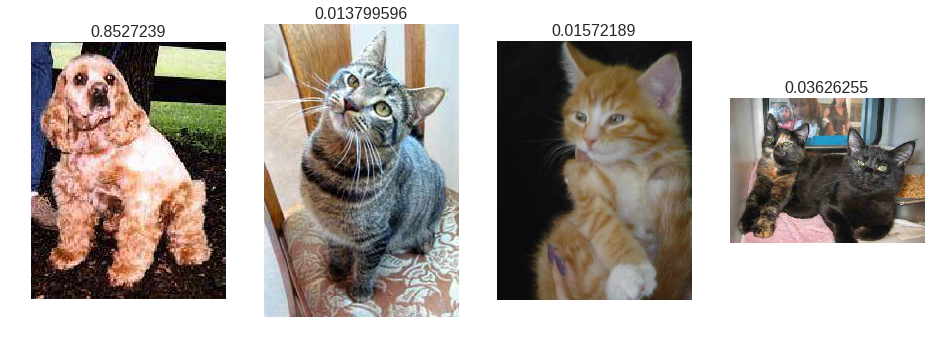

In [46]:
plot_val_with_title(rand_by_correct(True),"Correctly classified")